# Importación de librerías

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from src.video_processing_functions import *

# Experimentos para el algoritmo *Frequency Domain Image Blur Measure* (FM)

## Medición sobre todo el frame

A continuación se presenta un experimento para medir el tiempo de ejecución del algoritmo FM sobre todo el frame. Utilizaremos el video [focus_video.mov](resources/focus_video.mov) para la experimentación. 

La función `calculate_video_quality` recibe el path del video y retorna una lista con los valores de calidad de cada frame.  También abre una ventana mostrando el video.

In [4]:
# Define the path to the video
video_path = 'resources/focus_video.mov'

In [15]:
# Calculate the quality measurements of the video
quality_measurements = calculate_video_quality(video_path)

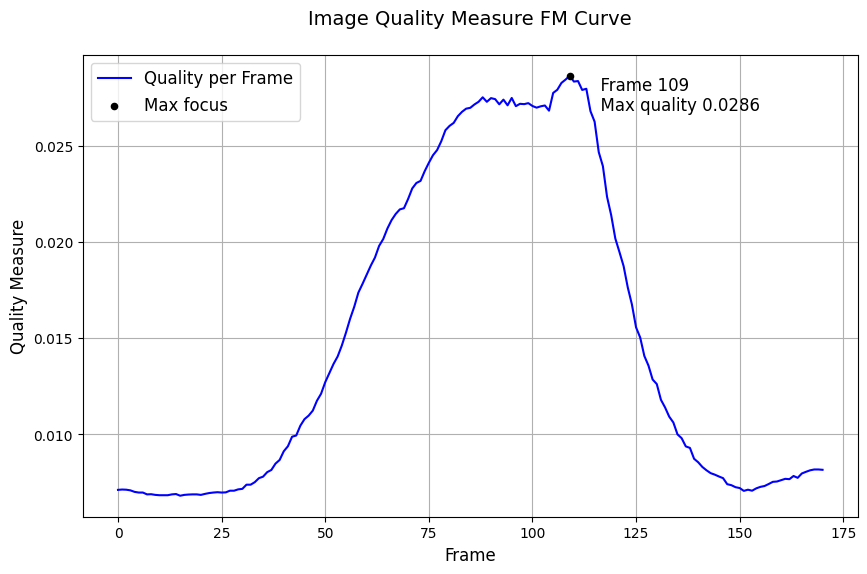

In [4]:
# Find the max focus value and its index
max_focus_index = quality_measurements.index(max(quality_measurements))
max_focus_value = round(max(quality_measurements), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements, label='Quality per Frame', color='blue')

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.002, f'  Frame {max_focus_index}\n  Max quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

Como se puede ver en la gráfica superior, la calidad de la imagen es variable a lo largo del video. La calidad empieza a subir a partir del frame 30, logra estabilizarse entre los frames 80 y 100, luego alcanza un **punto de máxima calidad de 0.0286 en el frame 109**, posteriormente disminuye.

## Medición sobre una ROI ubicada en el centro de la imagen

Área de la ROI de 5 o 10% del tamaño de la imagen original.

In [5]:
# Calculate the quality measurements of the video with a ROI
roi_percentage = 0.05
quality_measurements_roi = calculate_video_quality(video_path, roi_percentage=roi_percentage)

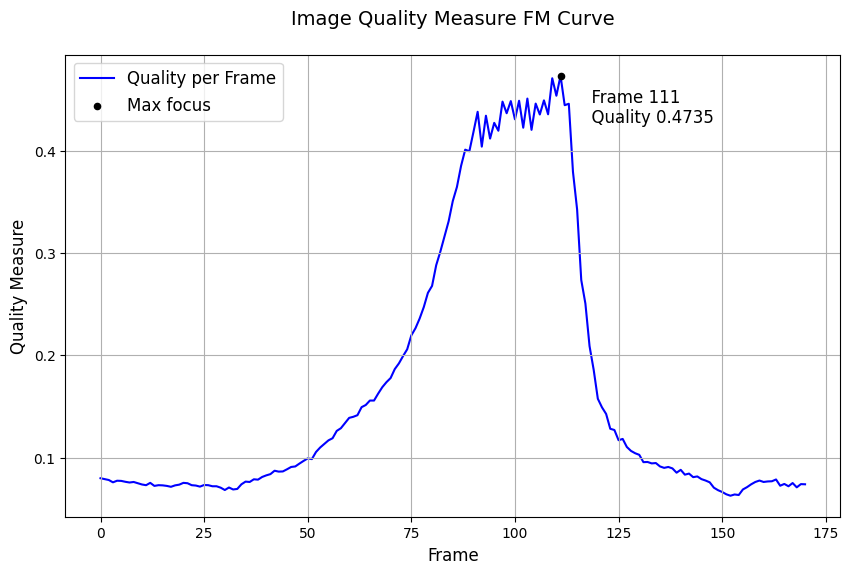

In [6]:
# Find the max focus value and its index
max_focus_index = quality_measurements_roi.index(max(quality_measurements_roi))
max_focus_value = round(max(quality_measurements_roi), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_roi, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [7]:
# Calculate the quality measurements of the video with a ROI
roi_percentage = 0.1
quality_measurements_roi = calculate_video_quality(video_path, roi_percentage=roi_percentage)

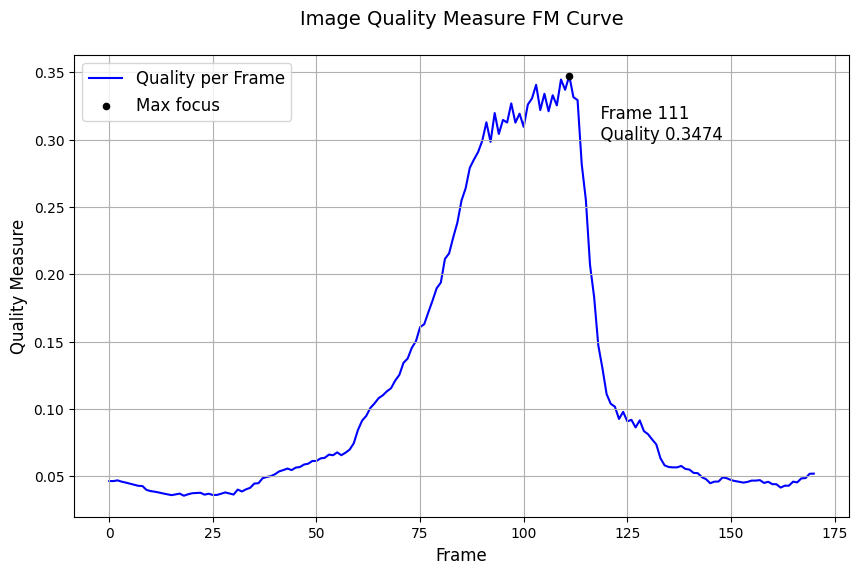

In [8]:
# Find the max focus value and its index
max_focus_index = quality_measurements_roi.index(max(quality_measurements_roi))
max_focus_value = round(max(quality_measurements_roi), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_roi, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

## Medición sobre una matriz de enfoque

Al dividir cada frame en una cuadrícula de $𝑁 \times M$ elementos rectangulares, se obtiene una medida de enfoque para cada sección, permitiendo detectar variaciones locales que podrían perderse en una evaluación global. Promediar estas medidas ofrece una representación precisa de la calidad de enfoque del frame completo, suavizando las fluctuaciones locales. En comparación con métodos que evalúan el frame completo o subregiones fijas, el enfoque de cuadrículas proporciona una mejor adaptabilidad y precisión.

In [46]:
quality_measurements_grid = calculate_video_quality_grid_with_roi(video_path, N=3, M=3, roi_percentage=0.25)

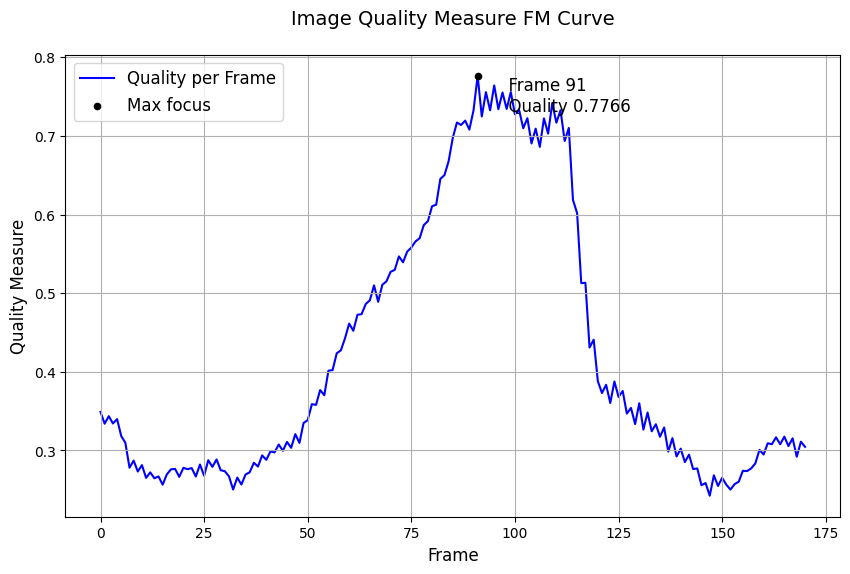

In [47]:
# Find the max focus value and its index
max_focus_index = quality_measurements_grid.index(max(quality_measurements_grid))
max_focus_value = round(max(quality_measurements_grid), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_grid, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [48]:
quality_measurements_grid = calculate_video_quality_grid_with_roi(video_path, N=7, M=5, roi_percentage=0.2)

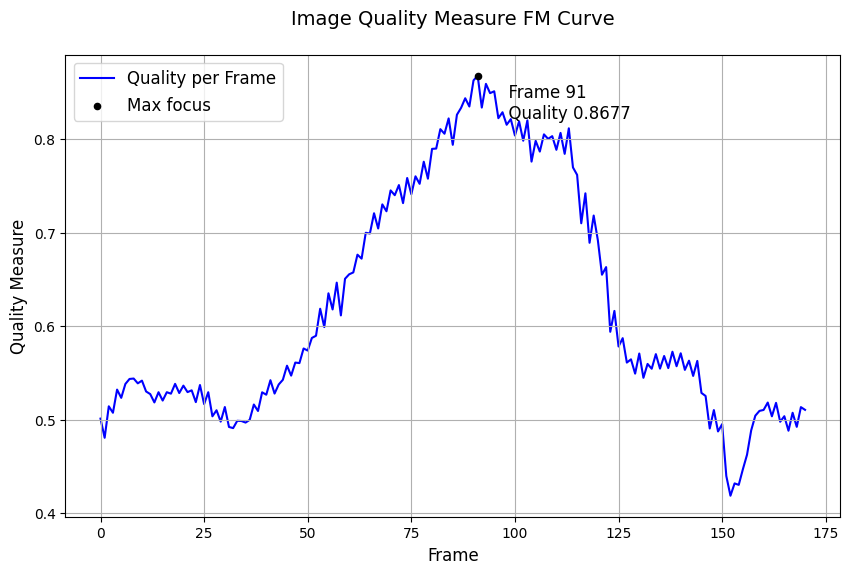

In [49]:
# Find the max focus value and its index
max_focus_index = quality_measurements_grid.index(max(quality_measurements_grid))
max_focus_value = round(max(quality_measurements_grid), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_grid, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

In [50]:
quality_measurements_grid = calculate_video_quality_grid_with_roi(video_path, N=7, M=7, roi_percentage=0.25)

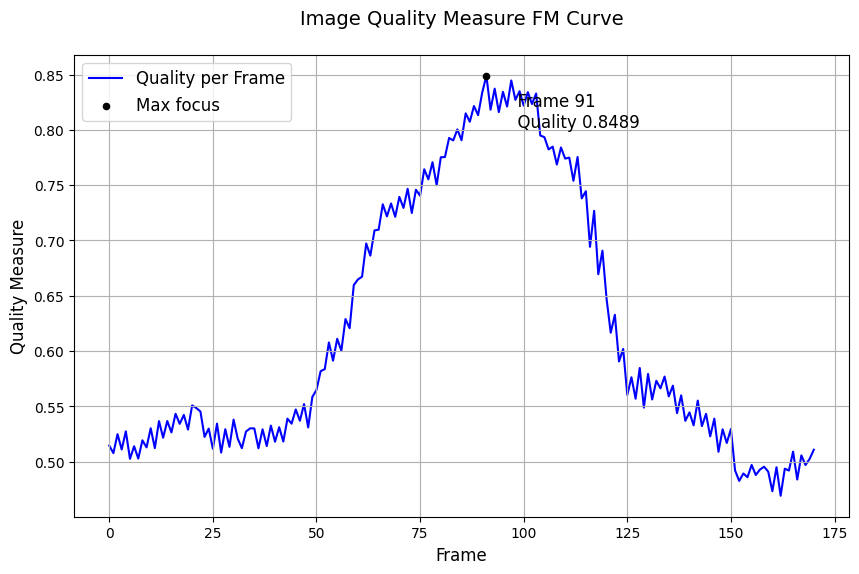

In [51]:
# Find the max focus value and its index
max_focus_index = quality_measurements_grid.index(max(quality_measurements_grid))
max_focus_value = round(max(quality_measurements_grid), 4)

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the quality measure curve
plt.plot(quality_measurements_grid, label='Quality per Frame', color='blue', zorder=1)

# Highlight the max focus value
plt.scatter(max_focus_index, max_focus_value, color='black', label='Max focus', zorder=5, edgecolors='black', s=20)
plt.text(max_focus_index + 5, max_focus_value - 0.05, f'  Frame {max_focus_index}\n  Quality {max_focus_value}', verticalalignment='bottom', fontsize=12)

# Add labels, title, and legend with increased font size
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Quality Measure', fontsize=12)
plt.title('Image Quality Measure FM Curve\n', fontsize=14)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()